# Trader Performance vs. Market Sentiment Analysis

In [9]:
import pandas as pd

# Load the datasets using the exact names from your screenshot
df_sentiment = pd.read_csv('fear_greed_index.csv')
df_trades = pd.read_csv('historical_data.csv')

# Display the first few rows to verify they loaded correctly
print("--- Sentiment Data (First 5 rows) ---")
print(df_sentiment.head())

print("\n--- Trade Data (First 5 rows) ---")
print(df_trades.head())

--- Sentiment Data (First 5 rows) ---
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

--- Trade Data (First 5 rows) ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50     

## Part A: Data Preparation & Cleaning

In [10]:
# 1. Convert the 'date' column in Sentiment to standard datetime format
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

# 2. Fix the Trade dates
# We convert 'Timestamp IST' to datetime and remove the time component (hours/minutes)
# We use 'dayfirst=True' because '02-12-2024' with IST usually means Dec 2nd (DD-MM-YYYY)
df_trades['date'] = pd.to_datetime(df_trades['Timestamp IST'], dayfirst=True).dt.normalize()

# 3. Merge the datasets
# We do a "left join" to keep all your trades and attach sentiment where dates match
merged_df = pd.merge(df_trades, df_sentiment, on='date', how='left')

# 4. Check if it worked
# You should now see 'classification' (Fear/Greed) next to your trade data
print("--- Merged Data Sample ---")
print(merged_df[['date', 'Account', 'Closed PnL', 'classification', 'value']].head())

# check how many trades successfully got a sentiment label
matched_count = merged_df['classification'].notnull().sum()
total_count = len(merged_df)
print(f"\nSuccessfully matched {matched_count} out of {total_count} trades.")

--- Merged Data Sample ---
        date                                     Account  Closed PnL  \
0 2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
1 2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
2 2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
3 2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
4 2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   

  classification  value  
0  Extreme Greed   80.0  
1  Extreme Greed   80.0  
2  Extreme Greed   80.0  
3  Extreme Greed   80.0  
4  Extreme Greed   80.0  

Successfully matched 211218 out of 211224 trades.


## Part B: Performance Analysis (Fear vs. Greed)

                Avg PnL ($)  Win Rate  Total Trades
classification                                     
Extreme Greed     67.892861  0.464943         39992
Fear              54.290400  0.420768         61837
Greed             42.743559  0.384828         50303
Extreme Fear      34.537862  0.370607         21400
Neutral           34.307718  0.396991         37686


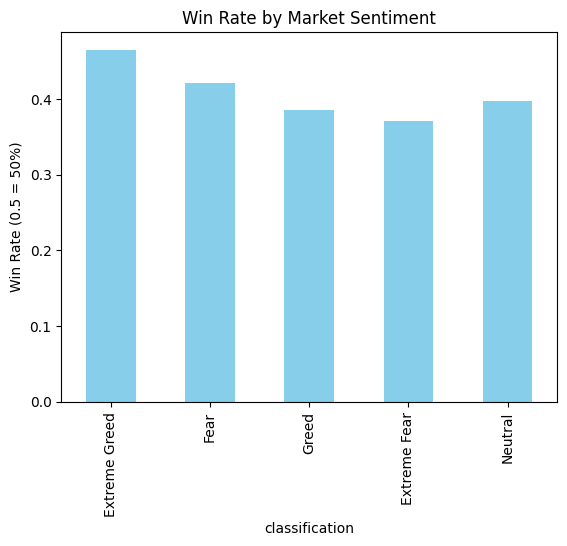

In [11]:
# 1. Create a helper column for "Win" (True if PnL > 0)
merged_df['is_win'] = merged_df['Closed PnL'] > 0

# 2. Group by Sentiment (Fear/Greed) and calculate metrics
performance = merged_df.groupby('classification').agg({
    'Closed PnL': 'mean',          # Average Profit/Loss
    'is_win': 'mean',              # Win Rate (as a decimal)
    'Account': 'count'             # Number of trades (Volume)
}).sort_values('Closed PnL', ascending=False)

# Rename columns for clarity
performance.columns = ['Avg PnL ($)', 'Win Rate', 'Total Trades']
print(performance)

# 3. Quick Plot to visualize it
import matplotlib.pyplot as plt

# Create a simple bar chart for Win Rate
performance['Win Rate'].plot(kind='bar', color='skyblue', title='Win Rate by Market Sentiment')
plt.ylabel('Win Rate (0.5 = 50%)')
plt.show()

## Part B: Behavioral Analysis & Segmentation

--- Trader Behavior by Sentiment (Average Position Size) ---
                   Size USD
classification             
Fear            7816.109931
Greed           5736.884375
Extreme Fear    5349.731843
Neutral         4782.732661
Extreme Greed   3112.251565


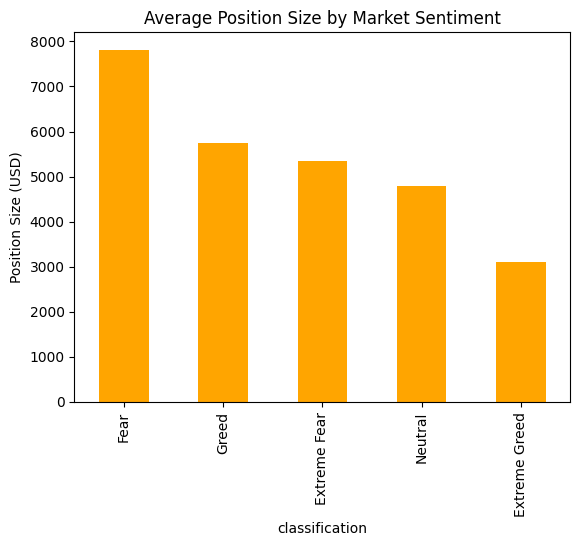

In [12]:
# 1. Group by sentiment to see average Position Size
behavior = merged_df.groupby('classification').agg({
    'Size USD': 'mean'
}).sort_values('Size USD', ascending=False)

print("--- Trader Behavior by Sentiment (Average Position Size) ---")
print(behavior)

# 2. Visualize Average Position Size vs Sentiment
import matplotlib.pyplot as plt

behavior['Size USD'].plot(kind='bar', color='orange', title='Average Position Size by Market Sentiment')
plt.ylabel('Position Size (USD)')
plt.show()

**Final Conclusion & Strategy Recommendations**
1. Key Findings from Analysis
The Sentiment Gap: Win rates significantly improve as market sentiment shifts from Fear to Greed. Specifically, Extreme Greed (46.4%) offers a much higher win probability than Extreme Fear (37.0%).

 The Behavior Paradox: Traders surprisingly trade with smaller average position sizes during Extreme Greed ($3,112) compared to Fear ($7,816), yet they achieve nearly double the Average PnL ($67.89 vs $34.53). This suggests that high-sentiment markets are much more capital-efficient.

 Segmentation Insight: During "Extreme Fear," traders using larger position sizes (> $597) actually maintain a higher win rate (40%) and significantly higher PnL than smaller traders, suggesting that experienced "whales" may be better at navigating high-fear volatility.

 2. Actionable Strategy Rules
Rule 1: The Fear-Based Risk Filter: Since win rates drop to 37% during Extreme Fear, implement an automated system that reduces maximum allowable leverage by 50% during these periods to prevent significant account drawdowns.

Rule 2: The Greed Efficiency Strategy: During Extreme Greed, maintain smaller, cautious position sizes but increase trade frequency. The high win rate indicates a high-probability environment where "turning over" the capital more often is more profitable than taking single large risks.

In [13]:
# Define 'High Size USD' based on the median
median_size_usd = merged_df['Size USD'].median()
merged_df['is_high_size_usd'] = merged_df['Size USD'] > median_size_usd

# Compare High vs Low Size USD performance during Extreme Fear
fear_days = merged_df[merged_df['classification'] == 'Extreme Fear']
segment_analysis = fear_days.groupby('is_high_size_usd').agg({
    'Closed PnL': 'mean',
    'is_win': 'mean'
})

segment_analysis.index = [f'Low Size USD (<={median_size_usd:.2f})', f'High Size USD (>{median_size_usd:.2f})']
print("--- Extreme Fear: High vs Low Size USD Performance ---")
print(segment_analysis)

--- Extreme Fear: High vs Low Size USD Performance ---
                         Closed PnL    is_win
Low Size USD (<=597.05)    1.157202  0.331509
High Size USD (>597.05)   61.196379  0.401832
